# Seismology & Cabled Arrays...

![cabled_array](./FIGURES/cabled_array.jpg)

The following notebook is intended to give you an overview of the key methods used to **download**, **process** and **view** seismological data. Hopefully, at the end of this notebook, you'll be able to play a little bit around with your own seismological data !

The functions and modules used in this notebook are largely inspired from those developped in the [**ObsPy**](https://github.com/obspy/obspy/wiki) package. ObsPy offers a broad range of [functions](https://docs.obspy.org/packages/index.html) whose aim is to standardize and ease the maniuplations of seismic data.

In this notebook we'll focus our study on the OOI (and ONC...) cabled arrays

### Let's import some useful packages !

In [86]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import copy
import pickle
from datetime import datetime
from obspy import UTCDateTime
import sys

In [2]:
#print(sys.path)

### Accessing the network metadata

The **metadata** contains all usefail details needed to describe the network (number of stations and coordinates, type of channel...). The **metadata** is different from the **waveform data** itself but they are complementary if we want to process correctly the waveforms.

Once you start a new research subject related to seismology, the first thing you need is the code (i.e. "AZ" or "BB") related to your network. A large number of networks are listed on [**IRIS**](http://ds.iris.edu/mda).

Here, we'll use the networks codes ["OO"](http://ds.iris.edu/mda/OO)(Ocean Observatories Initiative) and ["NV"](http://ds.iris.edu/mda/NV)(formerly Neptune Canada and now Ocean Networks Canada).

Let's see how to get the metaData associated to our network.

Firs we initialize a `Client` object which will help us getting the data by redirecting to the appropriate webservice. The argument given to `Client` can be the webservice name or it's URL. 

In [3]:
from obspy.clients.fdsn import Client

#client_name='IRIS'
client_name='http://service.iris.edu'

client=Client(client_name)

#print(client)

See below the list of pre-registered webservices in ObsPy:

In [4]:
from obspy.clients.fdsn.header import URL_MAPPINGS

for key in sorted(URL_MAPPINGS.keys()):
    #print("{0:<7} {1}".format(key,  URL_MAPPINGS[key]))

SyntaxError: unexpected EOF while parsing (<ipython-input-4-d02762988b93>, line 4)

Now that the client has been loaded we can retrieve our network info:

In [5]:
### Parameters

#net_code='NV'
net_code='NV,OO'

starttime = UTCDateTime("2015-01-01")
endtime = UTCDateTime("2015-01-02")


Inventory created at 2018-02-15T23:25:55.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2015-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			NV, OO
		Stations (18):
			NV.KEMF (Main Field)
			NV.NC27 (Node ODP1027, BC)
			NV.NC89 (Node ODP1089, BC)
			NV.NCBC (Barkley Canyon, BC)
			NV.NCHR (High Rise)
			OO.AXAS1 (RSN Axial Ashes 1)
			OO.AXAS2 (RSN Axial Ashes 2)
			OO.AXBA1 (RSN Axial Base 1)
			OO.AXCC1 (RSN Axial East Caldera 1)
			OO.AXEC1 (RSN Axial East Caldera 1)
			OO.AXEC2 (RSN Axial East Caldera 2)
			OO.AXEC3 (RSN Axial East Caldera 3)
			OO.AXID1 (RSN Axial International)
			OO.HYS11 (RSN Hydrate Summit 1-1)
			OO.HYS12 (RSN Hydrate Summit 1-2)
			OO.HYS13 (RSN Hydrate Summit 1-3)
			OO.HYS14 (RSN Hydrate Summit 1-4)
			OO.HYSB1 (RSN Hydrate Slope Base)
		Channels (0):



/home/baillard/PROGRAMS/anaconda3/envs/obspy_dev2/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


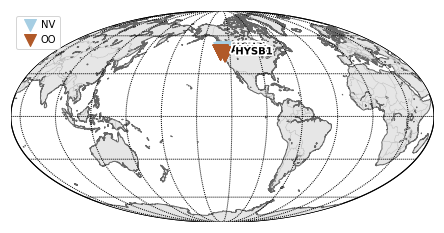

/home/baillard/PROGRAMS/anaconda3/envs/obspy_dev2/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


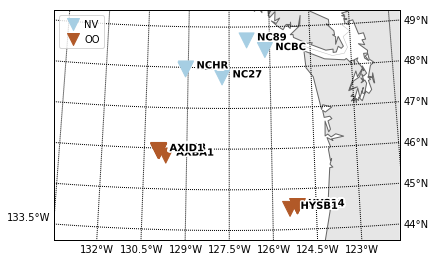

In [6]:
### Read network data

inventory = client.get_stations(network=net_code,
                                starttime=starttime,
                                endtime=endtime)

print(inventory)

### Plot inventory
plt.ioff()
inventory.plot(color_per_network=True) ### Plot global
inventory.plot(projection='local',color_per_network=True) ### Plot local
plt.show()

It is possible to be more specific when requesting the data, for example by choosing only the vertical channels (i.e. Z). Wildcards can be used to specify `network`,`station` or `channel` parameters. 

> **Tip**: To get more info you can also specify the `level`. When `level="response"` is set, it means we will retrieve the instrument response parameters which are indispensable to correct our waveforms, we'll see that later ;)

In [7]:
inventory = client.get_stations(network='OO',station='AXAS1,AXAS2',channel='*Z',
                                starttime=starttime,
                                endtime=endtime,level="channel")
print(inventory)


Inventory created at 2018-02-15T23:26:02.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2015-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OO
		Stations (2):
			OO.AXAS1 (RSN Axial Ashes 1)
			OO.AXAS2 (RSN Axial Ashes 2)
		Channels (8):
			OO.AXAS1..EHZ, OO.AXAS1..LHZ, OO.AXAS1..MHZ, OO.AXAS1..SHZ, 
			OO.AXAS2..EHZ, OO.AXAS2..LHZ, OO.AXAS2..MHZ, OO.AXAS2..SHZ


After loading the Inventory it's also possible to select some specific stations afterwards:

In [117]:
inventory_select = inventory.select(channel="*Z", station="AXAS1")
print(inventory_select)

Inventory created at 2018-02-15T23:26:11.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2015-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OO
		Stations (1):
			OO.AXAS1 (RSN Axial Ashes 1)
		Channels (4):
			OO.AXAS1..EHZ, OO.AXAS1..LHZ, OO.AXAS1..MHZ, OO.AXAS1..SHZ


### Instrument Response

Let's plot the instrument response for a specific channel:

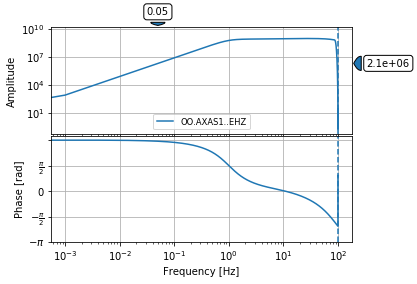

In [8]:
inventory = client.get_stations(network='OO',station='AXAS1',channel='EHZ',
                                starttime=starttime,
                                endtime=endtime,level="response")

inventory.plot_response(min_freq=0.001)
plt.show()

### Station inventory I/O

The inventory can also be written to a file, so that it can be stored locally on your computer for later use:

In [9]:
inventory = client.get_stations(network='OO',station='AXAS1',channel='*',
                                starttime=starttime,
                                endtime=endtime,level="response")

#help(inventory.write) # to check available format
inventory.write('station.xml',format='STATIONXML')


> **Tip**: You can check what's inside your `.xml` file by dragging and dropping it directly to your favorite webbrowser. Please take some time to do it as it contains some useful info.

> <font color=blue>**Info**</font>: [Station XML](https://www.fdsn.org/xml/station/) files have become the new standard to handle station metadata, it's much more comprehensible than dataless SEED files.

## Let's get some waveforms!

So far we have seen how to get the metadata associated to a network, it's now time to see what mother earth has to give!

### Reading seismograms

The method is pretty similar than the one used for getting stations metadata, except that here we'll use the `.get_waveforms` method instead of `.get_stations` (hard to make it simpler !). The output is then redirected to a `Stream` object instead of an `Inventory` object.

In [140]:
starttime = UTCDateTime("2015-01-22T10:34:21")
duration = 20

st = client.get_waveforms(network='OO',station='AX*',location="*",channel='E*Z',
                                starttime=starttime,
                                endtime=starttime+duration)

print(type(st))
print(st)
print(st.print_gaps())

<class 'obspy.core.stream.Stream'>
5 Trace(s) in Stream:
OO.AXAS1..EHZ | 2015-01-22T10:34:21.000000Z - 2015-01-22T10:34:41.000000Z | 200.0 Hz, 4001 samples
OO.AXAS2..EHZ | 2015-01-22T10:34:21.000000Z - 2015-01-22T10:34:41.000000Z | 200.0 Hz, 4001 samples
OO.AXEC1..EHZ | 2015-01-22T10:34:21.000000Z - 2015-01-22T10:34:41.000000Z | 200.0 Hz, 4001 samples
OO.AXEC3..EHZ | 2015-01-22T10:34:21.000000Z - 2015-01-22T10:34:41.000000Z | 200.0 Hz, 4001 samples
OO.AXID1..EHZ | 2015-01-22T10:34:21.000000Z - 2015-01-22T10:34:41.000000Z | 200.0 Hz, 4001 samples
Source            Last Sample                 Next Sample                 Delta           Samples 
Total: 0 gap(s) and 0 overlap(s)
None


A `Stream` object can have multiple `Trace` objects. To access some info about the trace you can do:

In [33]:
trace=st[0]
print(type(trace))
print(trace.stats)
print(trace.times())
print(trace.data)

<class 'obspy.core.trace.Trace'>
               network: OO
               station: AXAS1
              location: 
               channel: EHZ
             starttime: 2015-01-22T10:34:21.000000Z
               endtime: 2015-01-22T10:34:41.000000Z
         sampling_rate: 200.0
                 delta: 0.005
                  npts: 4001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 15, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 35328})
[  0.00000000e+00   5.00000000e-03   1.00000000e-02 ...,   1.99900000e+01
   1.99950000e+01   2.00000000e+01]
[ 10 110 140 ..., -55  10 116]


### Plotting seismograms

You can choose to plot the data by yourself by getting `trace.data` and `trace.times()` but ObsPy offers convenient methods to plot seismograms without directly dealing with data.

* Classic plots :

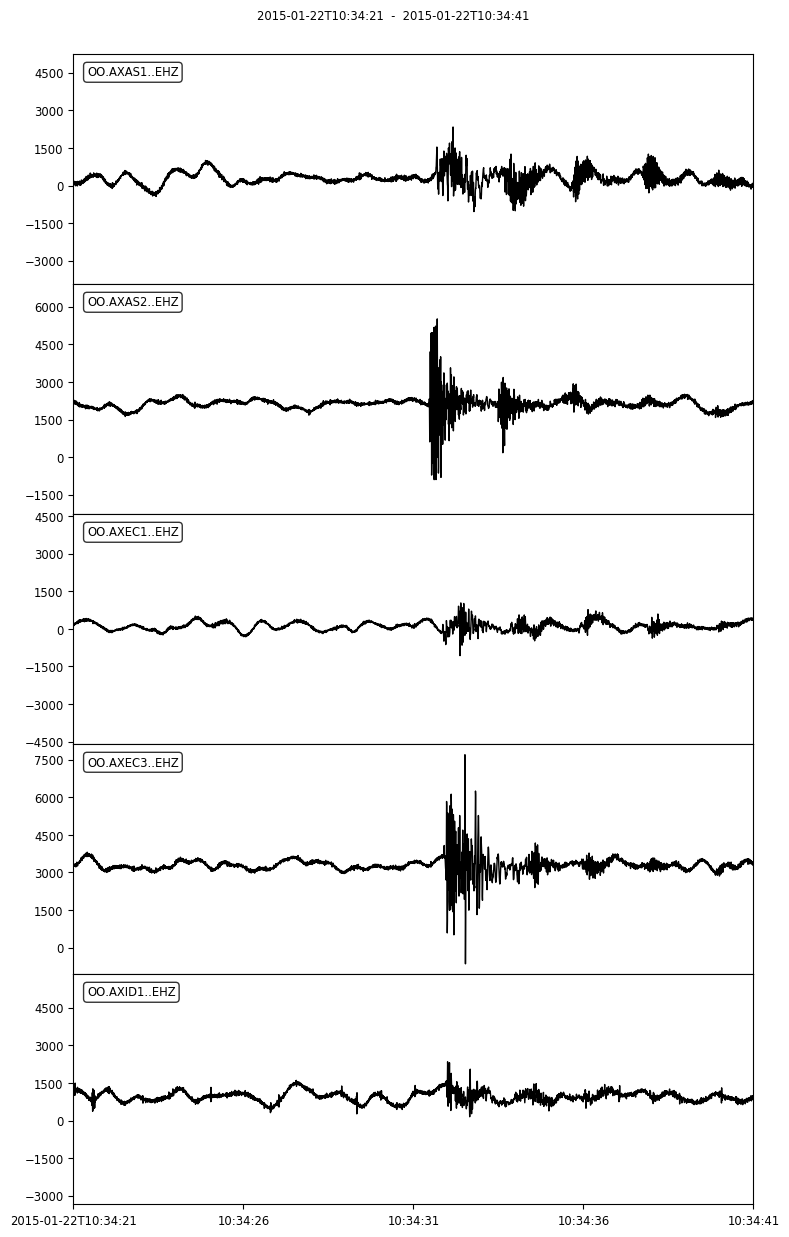

In [141]:
st.plot()

* Day plots:

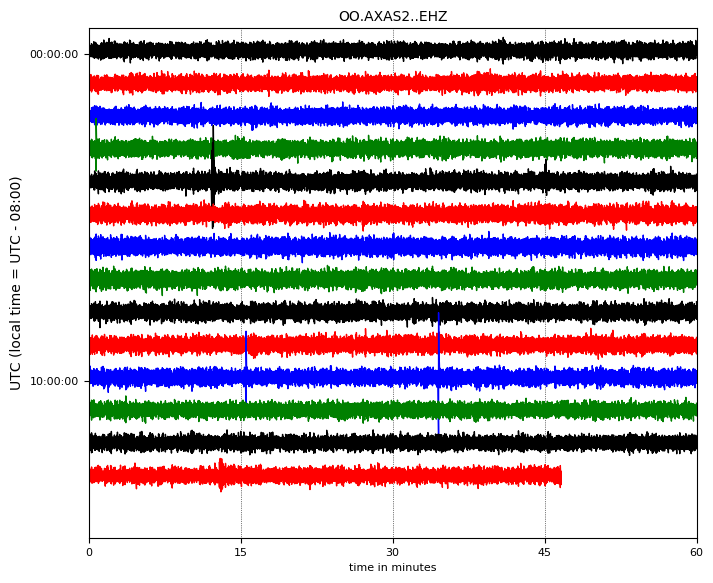

In [54]:
starttime = UTCDateTime("2015-01-22T00:00:00")

st = client.get_waveforms(network='OO',station='AXAS2',location="*",channel='E*Z',
                                starttime=starttime,
                                endtime=starttime+86400)

trace=st[0]
trace.plot(type='dayplot',color=['k', 'r', 'b', 'g'],interval=60) ## interval is in minutes and can be changed

> We can see that the above trace has missing values, let's see how we can handle gaps!

### Handling gaps

With the `Stream.merge` method we can fill gaps with user defined values. The method will merge traces that have same ids (i.e. same station + loc + channel code). 

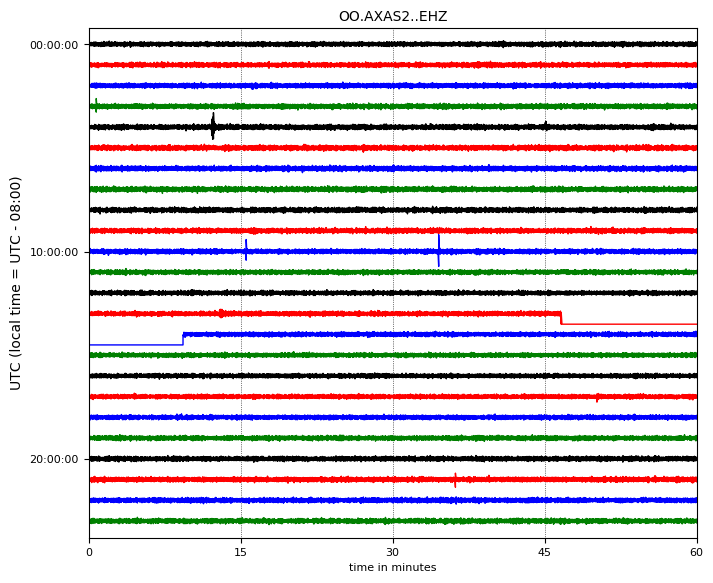

In [58]:
st_filled_gaps=None
st_filled_gaps=copy.deepcopy(st)
#print(st_filled_gaps[0].stats)
#print(st_filled_gaps[1].stats)
st_filled_gaps[0].stats.sampling_rate=200  # allow merging
st_filled_gaps.merge(method=0, fill_value=0)

trace=st_filled_gaps[0]
trace.plot(type='dayplot',color=['k', 'r', 'b', 'g'],interval=60) ## interval is in minutes and can be changed


Using ObsPy utilities to load data and detect gaps it's possible to plot a figure showing the data coverage for a specific network and for a defined time range, see example below for network ONC (~7 years):

![ONC](./FIGURES/ONC.png)

### Processing seismograms

#### Filtering

As you can see from the plot above, seimic onsets generated by earthquakes are sometimes hard to see on raw seismograms, this is particularly true in noisy environments and for low magnitudes earthquakes. It's generally a good idea to filter the seismograms to enhance the signal associated to an earthquake, let's take a single trace to see that.

In [137]:
starttime = UTCDateTime("2015-01-22T10:34:25")
duration = 20

st = client.get_waveforms(network='OO',station='AXAS1',location="*",channel='E*Z',
                                starttime=starttime,
                                endtime=starttime+duration)

st.merge()
trace=st[0]

> **Info**: Generally one should take care when choosing the higher corner frequency as it shouldn't exceed the Nyquist frequency, here, ObsPy will take care of that by sending a warning if necessary!

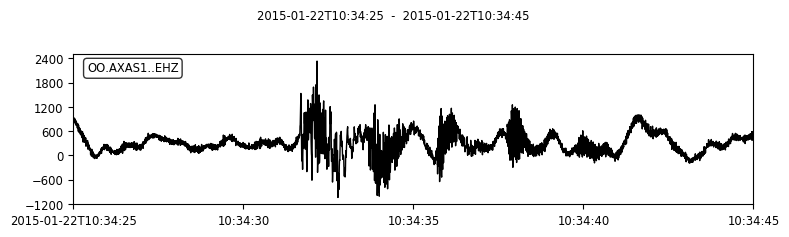

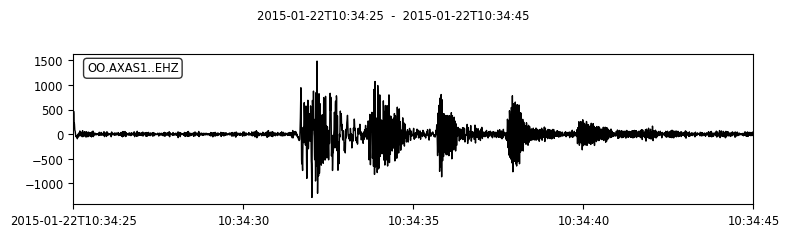

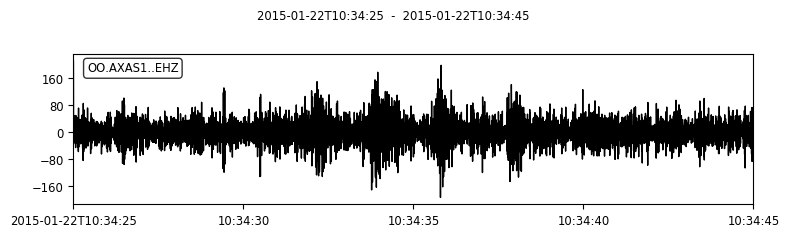

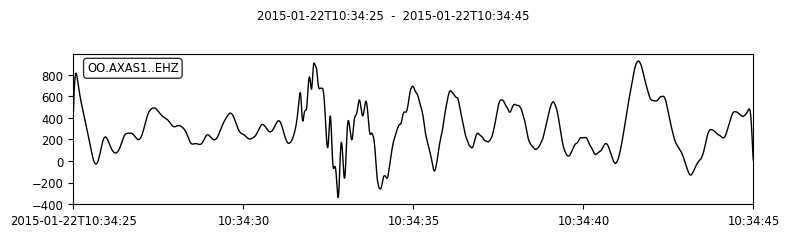

In [138]:
trace.plot()

#### Apply different to the trace

trace_filter=copy.copy(trace)
trace_filter.filter('bandpass', freqmin=5.0, freqmax=50,corners=3, zerophase=True)
trace_filter.plot()

trace_filter=copy.copy(trace)
trace_filter.filter('highpass', freq=50.0, corners=2, zerophase=True)
trace_filter.plot()

trace_filter=copy.copy(trace)
trace_filter.filter('lowpass', freq=5.0, corners=2, zerophase=True)
trace_filter.plot()

#### Spectrograms

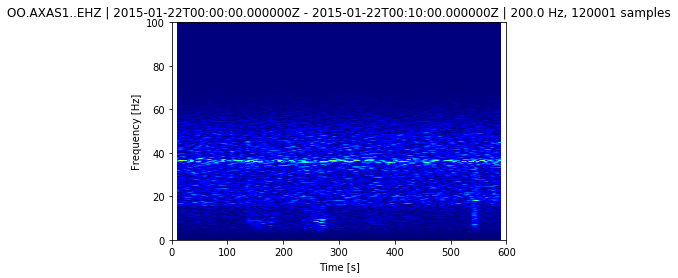

[ 12.   8.]


In [135]:
starttime = UTCDateTime("2015-01-22T00:00:00")
duration = 60*10

st = client.get_waveforms(network='OO',station='AXAS1',location="*",channel='E*Z',
                                starttime=starttime,
                                endtime=starttime+duration)

st.merge()
trace=st[0]

trace_filter=copy.copy(trace)
trace_filter.filter('bandpass', freqmin=5.0, freqmax=50,corners=3, zerophase=True)

#fig,ax=plt.subplots()

cmap= matplotlib.cm.get_cmap('jet')

trace_filter.spectrogram(cmap=cmap,wlen=20,per_lap=0.9)

fig=plt.gcf()
#PCM=ax.get_children()[0]
#plt.colorbar(PCM)

print(fig.get_size_inches()*2)
fig.set_size_inches(fig.get_size_inches()*2)


#### Remove instrumental response

### Saving seismograms to file

## Manipulate Earthquakes catalogs

In [ ]:


x=np.linspace(1,100,100)
y=np.sin(x)
plt.ion()
fig,ax=plt.subplots()
plt.plot(x,y)
fig,ax=plt.subplots()
plt.plot(x,y)

#1. qsdsq

